In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!cp "/content/drive/My Drive/datasets/super-res-large.zip" "dataset.zip"
!unzip -q  dataset.zip 

In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import Model
from keras.layers import Conv2D, PReLU, BatchNormalization, UpSampling2D, LeakyReLU, Dense, Input, add, Flatten

Using TensorFlow backend.


In [4]:
db_dir = "dataset-lg"

In [5]:
def get_train_data():
    X = []
    Y = []
    for x in os.listdir(db_dir + "/train/lr"):
        img_x = cv2.imread(db_dir + "/train/lr/" + x)
        X.append(img_x)
    
    X = np.array(X) / 255
    
    for y in os.listdir(db_dir + "/train/hr"):
        img_y = cv2.imread(db_dir + "/train/hr/" + y)
        Y.append(img_y)
  
    Y = np.array(Y) / 255 
    
    return X,Y


train_lr, train_hr = get_train_data()

In [6]:
def get_test_data():
    X = []
    Y = []

    for x in os.listdir(db_dir + "/test/lr"):
        img_x = cv2.imread(db_dir + "/test/lr/" + x)
        X.append(img_x)

    X = np.array(X) / 255

    for y in os.listdir(db_dir + "/test/hr"):
        
        img_y = cv2.imread(db_dir + "/test/hr/" + y)
        Y.append(img_y)
    Y = np.array(Y) / 255
    
    return X,Y


test_lr, test_hr = get_test_data()

In [7]:
print("train_shape ", train_lr.shape, " test_shape ", test_lr.shape )

num_res_block = 16
hr_shape = (train_hr.shape[1], train_hr.shape[2], train_hr.shape[3])
lr_shape = (train_lr.shape[1], train_lr.shape[2], train_lr.shape[3])


lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

train_shape  (2500, 25, 25, 3)  test_shape  (500, 25, 25, 3)


## Generator

In [8]:
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

## Generator model

In [9]:
def create_gen(gen_ip):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

## Discriminator

In [10]:


def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)

    
    return disc_model
    

## Discriminator model

In [16]:
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)
    


## VGG19

In [17]:
from keras.applications import VGG19

def build_vgg():
    vgg = VGG19(weights="imagenet")
    vgg.outputs = [vgg.layers[9].output]

    img = Input(shape=hr_shape)

    img_features = vgg(img)

    return Model(img, img_features)



## Combined Model

In [18]:


def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])


In [24]:

generator = create_gen(lr_ip)
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])

vgg = build_vgg()
vgg.trainable = False


gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)
gan_model.compile(loss=["binary_crossentropy","mse"], loss_weights=[1e-3, 1], optimizer="adam")



In [25]:
# generator.summary()
# discriminator.summary()
# discriminator.trainable = False
gan_model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 25, 25, 3)    0                                            
__________________________________________________________________________________________________
model_6 (Model)                 (None, 100, 100, 3)  2044291     input_1[0][0]                    
__________________________________________________________________________________________________
model_7 (Model)                 (None, 1)            30384961    model_6[1][0]                    
__________________________________________________________________________________________________
model_8 (Model)                 (None, 25, 25, 256)  143667240   model_6[1][0]                    
Total params: 176,096,492
Trainable params: 2,040,067
Non-trainable params: 174,056,425
____

In [26]:
batch_size = 50
train_lr_batches = []
train_hr_batches = []
for it in range(int(train_hr.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(train_hr[start_idx:end_idx])
    train_lr_batches.append(train_lr[start_idx:end_idx])

train_lr_batches = np.array(train_lr_batches)
train_hr_batches = np.array(train_hr_batches)


In [27]:
epoch_start = 280
epoch_end = 320

generator.load_weights("drive/My Drive/models/sr/gen/e_"+ str(epoch_start) +".h5")
discriminator.load_weights("drive/My Drive/models/sr/disc/e_"+ str(epoch_start) +".h5")

for e in range(epoch_start, epoch_end):
    
    gen_label = np.zeros((batch_size, 1))
    real_label = np.ones((batch_size,1))
    g_losses = []
    d_losses = []
    for b in range(len(train_hr_batches)):
        lr_imgs = train_lr_batches[b]
        hr_imgs = train_hr_batches[b]
        
        gen_imgs = generator.predict_on_batch(lr_imgs)

        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(gen_imgs, gen_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        discriminator.trainable = False

        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        image_features = vgg.predict(hr_imgs)

        g_loss,_,_ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    print("epoch:", e+1, "g_loss:", g_loss, "d_loss:", d_loss)
    if (e+1) % 10 == 0:
        discriminator.save_weights("drive/My Drive/models/sr/disc/e_"+ str(e+1) + ".h5")
        generator.save_weights("drive/My Drive/models/sr/gen/e_"+ str(e+1) + ".h5")
       


epoch: 281 g_loss: 5.98573486328125 d_loss: [0.03253425 0.9926    ]
epoch: 282 g_loss: 5.192313232421875 d_loss: [2.5469821e-04 9.9979997e-01]
epoch: 283 g_loss: 5.040073547363281 d_loss: [2.1927328e-07 1.0000000e+00]
epoch: 284 g_loss: 5.093583679199218 d_loss: [1.570502e-07 1.000000e+00]
epoch: 285 g_loss: 5.254647216796875 d_loss: [1.2442819e-04 1.0000000e+00]
epoch: 286 g_loss: 5.179488525390625 d_loss: [0.00428653 0.99920005]
epoch: 287 g_loss: 5.089338989257812 d_loss: [0.02015815 0.99840003]
epoch: 288 g_loss: 5.041529235839843 d_loss: [0.69026506 0.9654001 ]


KeyboardInterrupt: ignored

In [ ]:
generator.load_weights("drive/My Drive/models/sr/gen/e_300.h5")
discriminator.load_weights("drive/My Drive/models/sr/disc/e_300.h5")

In [ ]:
eval = gan_model.evaluate([test_lr, test_hr], [np.ones((500,1)), vgg.predict(test_hr)])
print(eval)

500/500 [==============================] - 5s 10ms/step
[7.515039932250977, 3.0002591609954834, 7.534689426422119]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


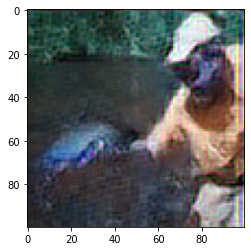

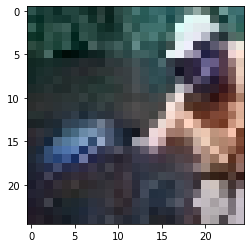

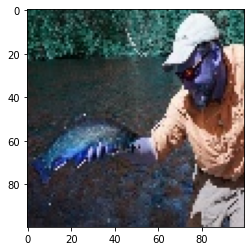

In [ ]:
pred = generator.predict_on_batch(train_lr_batches[7])
plt.imshow(pred[1])
plt.show()


plt.imshow((train_lr_batches[7][1]*255).astype(int))
plt.show()

plt.imshow( (train_hr_batches[7][1]*255).astype(int))
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


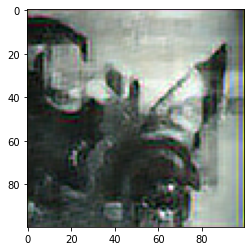

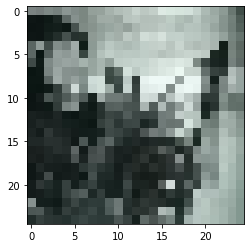

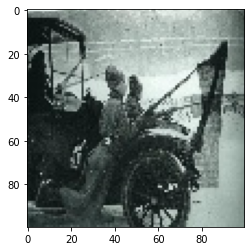

True

In [ ]:
test_pred = generator.predict_on_batch(test_lr[:10])

plt.imshow(test_pred[0])
plt.show()
cv2.imwrite("drive/My Drive/pred.jpg",test_pred[0]*255)



plt.imshow(test_lr[0])
plt.show()
cv2.imwrite("drive/My Drive/lr.jpg",test_lr[0]*255)

plt.imshow( test_hr[0])
plt.show()
cv2.imwrite("drive/My Drive/hr.jpg", test_hr[0]*255)


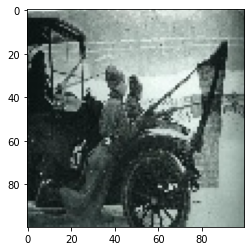

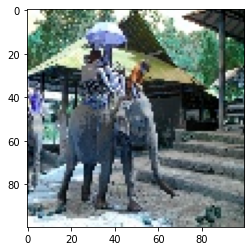

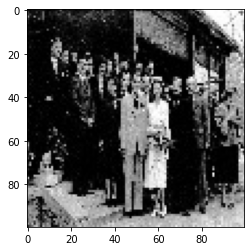

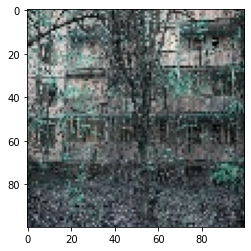

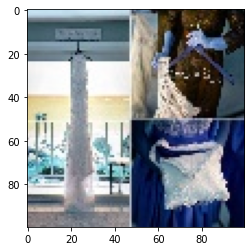

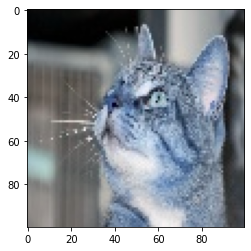

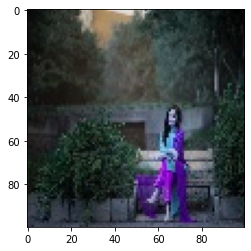

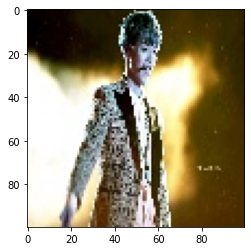

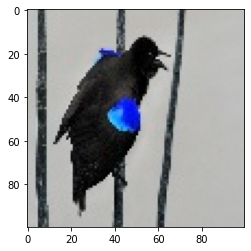

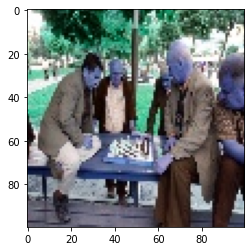

In [ ]:
count = 0
for x in os.listdir(db_dir + "/test/hr"):
    img_x = cv2.imread(db_dir + "/test/hr/" + x)
    plt.imshow(img_x)
    plt.show()
    cv2.imwrite("img/"+str(count)+".jpg", img_x)
    count += 1
    if count == 10:
        break


